# IQ TEST SEQUENCER BOT - RNN TEST

In [1]:
# Imports
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import LSTM, Dense
import random
from keras.layers import Bidirectional
from matplotlib import pyplot

## Read in the data

In [13]:
seqdataIn = pd.read_json('data/seq-public.json', orient='records')
print(seqdataIn)

                  stem               options            category    id
0           7,9,-1,5,?        [4, 2, -1, -3]            sequence     0
1        3,2,5/3,3/2,?  [1/4, 7/5, 3/4, 2/5]            sequence     1
2           1,2,5,26,?    [34, 841, 677, 37]            sequence     2
3            2,12,30,?      [50, 65, 75, 56]            sequence     3
4        2,1,2/3,1/2,?  [3/4, 1/4, 2/5, 5/6]            sequence     4
...                ...                   ...                 ...   ...
1071  20 22 25 30 37 ?                    []  sequence-reasoning  1090
1072        0 1 3 10 ?                    []  sequence-reasoning  1091
1073       5 15 10 215                    []  sequence-reasoning  1092
1074        1 2 5 29 ?    [34, 841, 866, 37]  sequence-reasoning  1093
1075         2 12 30 ?      [50, 65, 75, 56]  sequence-reasoning  1094

[1076 rows x 4 columns]


In [14]:
seqDataAns =pd.read_json('data/seq-public.answer.json',orient='index')
print(seqDataAns)

     answer                                               hint
0       [4]      A<sub>n+1</sub>=2<sup>5-n</sup>-A<sub>n</sub>
1       [2]  3/1, 4/2, 5/3, 6/4\n\nA<sub>n+1</sub>=A<sub>n<...
2       [3]        A<sub>n+1</sub>=A<sub>n</sub><sup>2</sup>+1
3       [4]                           A<sub>n</sub>=2n\*(2n-1)
4       [3]             4/2, 4/4, 4/6, 4/8\n\nA<sub>n</sub>=2n
...     ...                                                ...
1090     48                A<sub>n+1</sub>-A<sub>n</sub>=P(n);
1091    102           A<sub>n\*2</sub>=A<sub>n\*2-1</sub>^2+2;
1092   -115   A<sub>n</sub>=A<sub>n-2</sub>^2-A<sub>n-1</sub>;
1093    [3]  A<sub>n</sub>=A<sub>n-1</sub>^2+A<sub>n-2</sub...
1094    [4]                      A<sub>n</sub>=(2\*n-1)\*2\*n;

[1076 rows x 2 columns]


In [16]:
print(seqdataIn['options'])

0             [4, 2, -1, -3]
1       [1/4, 7/5, 3/4, 2/5]
2         [34, 841, 677, 37]
3           [50, 65, 75, 56]
4       [3/4, 1/4, 2/5, 5/6]
                ...         
1071                      []
1072                      []
1073                      []
1074      [34, 841, 866, 37]
1075        [50, 65, 75, 56]
Name: options, Length: 1076, dtype: object


####  Preprocess hints for printing - (not given with question)

In [4]:
def hint2txt(h):
    return h.replace('<sub>','_{').replace('</sub>','}').replace('<sup>','^{').replace('</sup>','}').replace('\n',' | ').replace('\*','*')
seqDataAns['hint'] = seqDataAns['hint'].map(lambda x: hint2txt(x))
print(seqDataAns['hint'])

0                                   A_{n+1}=2^{5-n}-A_{n}
1       3/1, 4/2, 5/3, 6/4 |  | A_{n+1}=A_{n}+1 |  | B...
2                                     A_{n+1}=A_{n}^{2}+1
3                                         A_{n}=2n*(2n-1)
4                        4/2, 4/4, 4/6, 4/8 |  | A_{n}=2n
                              ...                        
1090                                  A_{n+1}-A_{n}=P(n);
1091                               A_{n*2}=A_{n*2-1}^2+2;
1092                             A_{n}=A_{n-2}^2-A_{n-1};
1093                           A_{n}=A_{n-1}^2+A_{n-2}^2;
1094                                   A_{n}=(2*n-1)*2*n;
Name: hint, Length: 1076, dtype: object


#### NOTE: The sequences are recursive and can involve exponents and the index number. 
#### The answers also correspond to the index in the answer choices not the literal answer

## Fibonacci LSTM Test

In [5]:
#define fibonacci function
def fib(x):
    if x == 0:
        return 1
    elif x == 1:
        return 1
    else:
        return fib(x-1)+fib(x-2)

#returns n fibonacci numbers (starting with the 'start'th number) 
def fibSeq(n,start=0):
    s = []
    for i in range(start,start+n):
        s.append(fib(i))
    return s

print(fibSeq(10))
print(fibSeq(10,2))

[1, 1, 2, 3, 5, 8, 13, 21, 34, 55]
[2, 3, 5, 8, 13, 21, 34, 55, 89, 144]


In [6]:
# https://towardsdatascience.com/time-series-forecasting-with-recurrent-neural-networks-74674e289816
# https://stackabuse.com/solving-sequence-problems-with-lstm-in-keras/

# Test data preprocessing for RNN 
lookback = 2 #for fibonacci specifically only looks back to the previous 2 values
testSeq = fibSeq(20)
generator = TimeseriesGenerator(testSeq, testSeq, length=lookback, batch_size=1)
# print each sample
for i in range(len(generator)):
	x, y = generator[i]
	print('%s => %s' % (x, y))

[[1 1]] => [2]
[[1 2]] => [3]
[[2 3]] => [5]
[[3 5]] => [8]
[[5 8]] => [13]
[[ 8 13]] => [21]
[[13 21]] => [34]
[[21 34]] => [55]
[[34 55]] => [89]
[[55 89]] => [144]
[[ 89 144]] => [233]
[[144 233]] => [377]
[[233 377]] => [610]
[[377 610]] => [987]
[[610 987]] => [1597]
[[ 987 1597]] => [2584]
[[1597 2584]] => [4181]
[[2584 4181]] => [6765]


In [7]:
# make train and test data sets
m = 30
seqLen = 5
masterSeq = fibSeq(m) #get first 50 fib numbers
#make set of specific length 
def fibSet(x,l):
    s = []
    for i in range(x):
        t = random.randint(0,m-l)
        s.append(masterSeq[t:t+l])
    return s
train_fib = fibSet(10,seqLen)
test_fib = fibSet(1,seqLen)
print(train_fib)
print(test_fib)

[[2, 3, 5, 8, 13], [121393, 196418, 317811, 514229, 832040], [233, 377, 610, 987, 1597], [13, 21, 34, 55, 89], [377, 610, 987, 1597, 2584], [17711, 28657, 46368, 75025, 121393], [46368, 75025, 121393, 196418, 317811], [987, 1597, 2584, 4181, 6765], [89, 144, 233, 377, 610], [121393, 196418, 317811, 514229, 832040]]
[[6765, 10946, 17711, 28657, 46368]]


In [8]:
#reshape data for lstm
fib_look = 2 #for fibonacci specifically only looks back to the previous 2 values
X_train = []
y_train = []
X_test = []
y_test = []

#train
for t in train_fib:
    train_gen = TimeseriesGenerator(t, t, length=fib_look, batch_size=1)
    for i in range(len(train_gen)):
        x, y = train_gen[i]
        X_train.append(x)
        y_train.append(y)

X_train = np.squeeze(np.asarray(X_train))
y_train = np.squeeze(np.asarray(y_train))
#reshape to [# samples, #time steps, #features] -> [10*segments, 2, 1]
X_train = X_train.reshape((X_train.shape[0],fib_look,1))

#test
for t in test_fib:
    test_gen = TimeseriesGenerator(t, t, length=fib_look, batch_size=1)
    for i in range(len(test_gen)):
        x, y = test_gen[i]
        X_test.append(x)
        y_test.append(y)

X_test = np.squeeze(np.asarray(X_test))
y_test = np.squeeze(np.asarray(y_test))
#reshape to [# samples, #time steps, #features] -> [10*segments, 2, 1]
X_test = X_test.reshape((X_test.shape[0],fib_look,1))

In [10]:
print("X train" + str(X_train))
print("y train" + str(y_train))
print("X test" + str(X_test))
print("y test" + str(y_test))

X train[[[     2]
  [     3]]

 [[     3]
  [     5]]

 [[     5]
  [     8]]

 [[121393]
  [196418]]

 [[196418]
  [317811]]

 [[317811]
  [514229]]

 [[   233]
  [   377]]

 [[   377]
  [   610]]

 [[   610]
  [   987]]

 [[    13]
  [    21]]

 [[    21]
  [    34]]

 [[    34]
  [    55]]

 [[   377]
  [   610]]

 [[   610]
  [   987]]

 [[   987]
  [  1597]]

 [[ 17711]
  [ 28657]]

 [[ 28657]
  [ 46368]]

 [[ 46368]
  [ 75025]]

 [[ 46368]
  [ 75025]]

 [[ 75025]
  [121393]]

 [[121393]
  [196418]]

 [[   987]
  [  1597]]

 [[  1597]
  [  2584]]

 [[  2584]
  [  4181]]

 [[    89]
  [   144]]

 [[   144]
  [   233]]

 [[   233]
  [   377]]

 [[121393]
  [196418]]

 [[196418]
  [317811]]

 [[317811]
  [514229]]]
y train[     5      8     13 317811 514229 832040    610    987   1597     34
     55     89    987   1597   2584  46368  75025 121393 121393 196418
 317811   2584   4181   6765    233    377    610 317811 514229 832040]
X test[[[ 6765]
  [10946]]

 [[10946]
  [17711]]

 [

In [31]:
# make Simple LSTM
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(fib_look, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse',metrics=['mse'])

In [32]:
#train model
history = model.fit(X_train, y_train, epochs=1000, validation_split=0.2, verbose=1)

Epoch 1/1000
1/1 [==============================] - 0s 172ms/step - loss: 38000226304.0000 - mse: 38000226304.0000 - val_loss: 88859.2266 - val_mse: 88859.2266
Epoch 2/1000
1/1 [==============================] - 0s 16ms/step - loss: 37789618176.0000 - mse: 37789618176.0000 - val_loss: 88257.6016 - val_mse: 88257.6016
Epoch 3/1000
1/1 [==============================] - 0s 18ms/step - loss: 37611683840.0000 - mse: 37611683840.0000 - val_loss: 87700.2422 - val_mse: 87700.2422
Epoch 4/1000
1/1 [==============================] - 0s 22ms/step - loss: 37432868864.0000 - mse: 37432868864.0000 - val_loss: 87168.6250 - val_mse: 87168.6250
Epoch 5/1000
1/1 [==============================] - 0s 17ms/step - loss: 37236871168.0000 - mse: 37236871168.0000 - val_loss: 86650.9141 - val_mse: 86650.9141
Epoch 6/1000
1/1 [==============================] - 0s 15ms/step - loss: 37057490944.0000 - mse: 37057490944.0000 - val_loss: 86139.8047 - val_mse: 86139.8047
Epoch 7/1000
1/1 [===========================

1/1 [==============================] - 0s 14ms/step - loss: 34095036.0000 - mse: 34095036.0000 - val_loss: 46.1603 - val_mse: 46.1603
Epoch 106/1000
1/1 [==============================] - 0s 15ms/step - loss: 34762004.0000 - mse: 34762004.0000 - val_loss: 44.7202 - val_mse: 44.7202
Epoch 107/1000
1/1 [==============================] - 0s 14ms/step - loss: 34586956.0000 - mse: 34586956.0000 - val_loss: 42.4149 - val_mse: 42.4149
Epoch 108/1000
1/1 [==============================] - 0s 15ms/step - loss: 33673388.0000 - mse: 33673388.0000 - val_loss: 39.4551 - val_mse: 39.4551
Epoch 109/1000
1/1 [==============================] - 0s 14ms/step - loss: 32142014.0000 - mse: 32142014.0000 - val_loss: 36.0541 - val_mse: 36.0541
Epoch 110/1000
1/1 [==============================] - 0s 13ms/step - loss: 30121862.0000 - mse: 30121862.0000 - val_loss: 32.4404 - val_mse: 32.4404
Epoch 111/1000
1/1 [==============================] - 0s 13ms/step - loss: 27740906.0000 - mse: 27740906.0000 - val_loss:

1/1 [==============================] - 0s 14ms/step - loss: 74.2547 - mse: 74.2547 - val_loss: 18.3815 - val_mse: 18.3815
Epoch 220/1000
1/1 [==============================] - 0s 14ms/step - loss: 41.4928 - mse: 41.4928 - val_loss: 18.3591 - val_mse: 18.3591
Epoch 221/1000
1/1 [==============================] - 0s 13ms/step - loss: 19.5474 - mse: 19.5474 - val_loss: 18.3382 - val_mse: 18.3382
Epoch 222/1000
1/1 [==============================] - 0s 13ms/step - loss: 7.2429 - mse: 7.2429 - val_loss: 18.3191 - val_mse: 18.3191
Epoch 223/1000
1/1 [==============================] - 0s 15ms/step - loss: 2.5029 - mse: 2.5029 - val_loss: 18.3018 - val_mse: 18.3018
Epoch 224/1000
1/1 [==============================] - 0s 14ms/step - loss: 3.7672 - mse: 3.7672 - val_loss: 18.2862 - val_mse: 18.2862
Epoch 225/1000
1/1 [==============================] - 0s 14ms/step - loss: 9.2867 - mse: 9.2867 - val_loss: 18.2727 - val_mse: 18.2727
Epoch 226/1000
1/1 [==============================] - 0s 14ms/st

Epoch 340/1000
1/1 [==============================] - 0s 14ms/step - loss: 1.3190 - mse: 1.3190 - val_loss: 18.2721 - val_mse: 18.2721
Epoch 341/1000
1/1 [==============================] - 0s 13ms/step - loss: 1.3180 - mse: 1.3180 - val_loss: 18.2724 - val_mse: 18.2724
Epoch 342/1000
1/1 [==============================] - 0s 14ms/step - loss: 1.3172 - mse: 1.3172 - val_loss: 18.2727 - val_mse: 18.2727
Epoch 343/1000
1/1 [==============================] - 0s 13ms/step - loss: 1.3164 - mse: 1.3164 - val_loss: 18.2729 - val_mse: 18.2729
Epoch 344/1000
1/1 [==============================] - 0s 13ms/step - loss: 1.3118 - mse: 1.3118 - val_loss: 18.2731 - val_mse: 18.2731
Epoch 345/1000
1/1 [==============================] - 0s 13ms/step - loss: 1.3117 - mse: 1.3117 - val_loss: 18.2733 - val_mse: 18.2733
Epoch 346/1000
1/1 [==============================] - 0s 13ms/step - loss: 1.3120 - mse: 1.3120 - val_loss: 18.2737 - val_mse: 18.2737
Epoch 347/1000
1/1 [==============================] - 0

Epoch 401/1000
1/1 [==============================] - 0s 13ms/step - loss: 1.2881 - mse: 1.2881 - val_loss: 18.0840 - val_mse: 18.0840
Epoch 402/1000
1/1 [==============================] - 0s 13ms/step - loss: 1.2878 - mse: 1.2878 - val_loss: 18.0800 - val_mse: 18.0800
Epoch 403/1000
1/1 [==============================] - 0s 13ms/step - loss: 1.2874 - mse: 1.2874 - val_loss: 18.0762 - val_mse: 18.0762
Epoch 404/1000
1/1 [==============================] - 0s 14ms/step - loss: 1.2870 - mse: 1.2870 - val_loss: 18.0722 - val_mse: 18.0722
Epoch 405/1000
1/1 [==============================] - 0s 13ms/step - loss: 1.2867 - mse: 1.2867 - val_loss: 18.0681 - val_mse: 18.0681
Epoch 406/1000
1/1 [==============================] - 0s 14ms/step - loss: 1.2863 - mse: 1.2863 - val_loss: 18.0644 - val_mse: 18.0644
Epoch 407/1000
1/1 [==============================] - 0s 13ms/step - loss: 1.2860 - mse: 1.2860 - val_loss: 18.0603 - val_mse: 18.0603
Epoch 408/1000
1/1 [==============================] - 0

Epoch 462/1000
1/1 [==============================] - 0s 13ms/step - loss: 1.2717 - mse: 1.2717 - val_loss: 17.8424 - val_mse: 17.8424
Epoch 463/1000
1/1 [==============================] - 0s 13ms/step - loss: 1.2714 - mse: 1.2714 - val_loss: 17.8382 - val_mse: 17.8382
Epoch 464/1000
1/1 [==============================] - 0s 13ms/step - loss: 1.2711 - mse: 1.2711 - val_loss: 17.8341 - val_mse: 17.8341
Epoch 465/1000
1/1 [==============================] - 0s 16ms/step - loss: 1.2708 - mse: 1.2708 - val_loss: 17.8302 - val_mse: 17.8302
Epoch 466/1000
1/1 [==============================] - 0s 14ms/step - loss: 1.2705 - mse: 1.2705 - val_loss: 17.8261 - val_mse: 17.8261
Epoch 467/1000
1/1 [==============================] - 0s 14ms/step - loss: 1.2702 - mse: 1.2702 - val_loss: 17.8219 - val_mse: 17.8219
Epoch 468/1000
1/1 [==============================] - 0s 13ms/step - loss: 1.2699 - mse: 1.2699 - val_loss: 17.8180 - val_mse: 17.8180
Epoch 469/1000
1/1 [==============================] - 0

Epoch 523/1000
1/1 [==============================] - 0s 14ms/step - loss: 1.2546 - mse: 1.2546 - val_loss: 17.5971 - val_mse: 17.5971
Epoch 524/1000
1/1 [==============================] - 0s 14ms/step - loss: 1.2543 - mse: 1.2543 - val_loss: 17.5932 - val_mse: 17.5932
Epoch 525/1000
1/1 [==============================] - 0s 14ms/step - loss: 1.2540 - mse: 1.2540 - val_loss: 17.5893 - val_mse: 17.5893
Epoch 526/1000
1/1 [==============================] - 0s 13ms/step - loss: 1.2538 - mse: 1.2538 - val_loss: 17.5852 - val_mse: 17.5852
Epoch 527/1000
1/1 [==============================] - 0s 13ms/step - loss: 1.2535 - mse: 1.2535 - val_loss: 17.5814 - val_mse: 17.5814
Epoch 528/1000
1/1 [==============================] - 0s 13ms/step - loss: 1.2533 - mse: 1.2533 - val_loss: 17.5772 - val_mse: 17.5772
Epoch 529/1000
1/1 [==============================] - 0s 13ms/step - loss: 1.2530 - mse: 1.2530 - val_loss: 17.5735 - val_mse: 17.5735
Epoch 530/1000
1/1 [==============================] - 0

Epoch 584/1000
1/1 [==============================] - 0s 13ms/step - loss: 1.2392 - mse: 1.2392 - val_loss: 17.3565 - val_mse: 17.3565
Epoch 585/1000
1/1 [==============================] - 0s 13ms/step - loss: 1.2390 - mse: 1.2390 - val_loss: 17.3524 - val_mse: 17.3524
Epoch 586/1000
1/1 [==============================] - 0s 14ms/step - loss: 1.2350 - mse: 1.2350 - val_loss: 17.3487 - val_mse: 17.3487
Epoch 587/1000
1/1 [==============================] - 0s 13ms/step - loss: 1.2348 - mse: 1.2348 - val_loss: 17.3448 - val_mse: 17.3448
Epoch 588/1000
1/1 [==============================] - 0s 13ms/step - loss: 1.2345 - mse: 1.2345 - val_loss: 17.3408 - val_mse: 17.3408
Epoch 589/1000
1/1 [==============================] - 0s 13ms/step - loss: 1.2343 - mse: 1.2343 - val_loss: 17.3371 - val_mse: 17.3371
Epoch 590/1000
1/1 [==============================] - 0s 14ms/step - loss: 1.2340 - mse: 1.2340 - val_loss: 17.3331 - val_mse: 17.3331
Epoch 591/1000
1/1 [==============================] - 0

Epoch 645/1000
1/1 [==============================] - 0s 13ms/step - loss: 1.2217 - mse: 1.2217 - val_loss: 17.1231 - val_mse: 17.1231
Epoch 646/1000
1/1 [==============================] - 0s 13ms/step - loss: 1.2215 - mse: 1.2215 - val_loss: 17.1194 - val_mse: 17.1194
Epoch 647/1000
1/1 [==============================] - 0s 13ms/step - loss: 1.2213 - mse: 1.2213 - val_loss: 17.1157 - val_mse: 17.1157
Epoch 648/1000
1/1 [==============================] - 0s 13ms/step - loss: 1.2210 - mse: 1.2210 - val_loss: 17.1118 - val_mse: 17.1118
Epoch 649/1000
1/1 [==============================] - 0s 13ms/step - loss: 1.2208 - mse: 1.2208 - val_loss: 17.1080 - val_mse: 17.1080
Epoch 650/1000
1/1 [==============================] - 0s 13ms/step - loss: 1.2206 - mse: 1.2206 - val_loss: 17.1042 - val_mse: 17.1042
Epoch 651/1000
1/1 [==============================] - 0s 13ms/step - loss: 1.2241 - mse: 1.2241 - val_loss: 17.1007 - val_mse: 17.1007
Epoch 652/1000
1/1 [==============================] - 0

Epoch 706/1000
1/1 [==============================] - 0s 14ms/step - loss: 1.2091 - mse: 1.2091 - val_loss: 16.8995 - val_mse: 16.8995
Epoch 707/1000
1/1 [==============================] - 0s 13ms/step - loss: 1.2088 - mse: 1.2088 - val_loss: 16.8959 - val_mse: 16.8959
Epoch 708/1000
1/1 [==============================] - 0s 15ms/step - loss: 1.2086 - mse: 1.2086 - val_loss: 16.8922 - val_mse: 16.8922
Epoch 709/1000
1/1 [==============================] - 0s 14ms/step - loss: 1.2084 - mse: 1.2084 - val_loss: 16.8888 - val_mse: 16.8888
Epoch 710/1000
1/1 [==============================] - 0s 13ms/step - loss: 1.2083 - mse: 1.2083 - val_loss: 16.8851 - val_mse: 16.8851
Epoch 711/1000
1/1 [==============================] - 0s 13ms/step - loss: 1.2081 - mse: 1.2081 - val_loss: 16.8815 - val_mse: 16.8815
Epoch 712/1000
1/1 [==============================] - 0s 14ms/step - loss: 1.2079 - mse: 1.2079 - val_loss: 16.8781 - val_mse: 16.8781
Epoch 713/1000
1/1 [==============================] - 0

Epoch 767/1000
1/1 [==============================] - 0s 14ms/step - loss: 1.2013 - mse: 1.2013 - val_loss: 16.6863 - val_mse: 16.6863
Epoch 768/1000
1/1 [==============================] - 0s 14ms/step - loss: 1.2012 - mse: 1.2012 - val_loss: 16.6829 - val_mse: 16.6829
Epoch 769/1000
1/1 [==============================] - 0s 14ms/step - loss: 1.2010 - mse: 1.2010 - val_loss: 16.6796 - val_mse: 16.6796
Epoch 770/1000
1/1 [==============================] - 0s 13ms/step - loss: 1.2009 - mse: 1.2009 - val_loss: 16.6761 - val_mse: 16.6761
Epoch 771/1000
1/1 [==============================] - 0s 13ms/step - loss: 1.1969 - mse: 1.1969 - val_loss: 16.6727 - val_mse: 16.6727
Epoch 772/1000
1/1 [==============================] - 0s 13ms/step - loss: 1.1967 - mse: 1.1967 - val_loss: 16.6693 - val_mse: 16.6693
Epoch 773/1000
1/1 [==============================] - 0s 14ms/step - loss: 1.1965 - mse: 1.1965 - val_loss: 16.6660 - val_mse: 16.6660
Epoch 774/1000
1/1 [==============================] - 0

Epoch 828/1000
1/1 [==============================] - 0s 14ms/step - loss: 1.1909 - mse: 1.1909 - val_loss: 16.4839 - val_mse: 16.4839
Epoch 829/1000
1/1 [==============================] - 0s 13ms/step - loss: 1.1907 - mse: 1.1907 - val_loss: 16.4808 - val_mse: 16.4808
Epoch 830/1000
1/1 [==============================] - 0s 13ms/step - loss: 1.1905 - mse: 1.1905 - val_loss: 16.4775 - val_mse: 16.4775
Epoch 831/1000
1/1 [==============================] - 0s 13ms/step - loss: 1.1867 - mse: 1.1867 - val_loss: 16.4743 - val_mse: 16.4743
Epoch 832/1000
1/1 [==============================] - 0s 13ms/step - loss: 1.1865 - mse: 1.1865 - val_loss: 16.4710 - val_mse: 16.4710
Epoch 833/1000
1/1 [==============================] - 0s 14ms/step - loss: 1.1863 - mse: 1.1863 - val_loss: 16.4678 - val_mse: 16.4678
Epoch 834/1000
1/1 [==============================] - 0s 13ms/step - loss: 1.1862 - mse: 1.1862 - val_loss: 16.4646 - val_mse: 16.4646
Epoch 835/1000
1/1 [==============================] - 0

Epoch 889/1000
1/1 [==============================] - 0s 13ms/step - loss: 1.1773 - mse: 1.1773 - val_loss: 16.2922 - val_mse: 16.2922
Epoch 890/1000
1/1 [==============================] - 0s 13ms/step - loss: 1.1771 - mse: 1.1771 - val_loss: 16.2890 - val_mse: 16.2890
Epoch 891/1000
1/1 [==============================] - 0s 14ms/step - loss: 1.1770 - mse: 1.1770 - val_loss: 16.2861 - val_mse: 16.2861
Epoch 892/1000
1/1 [==============================] - 0s 13ms/step - loss: 1.1769 - mse: 1.1769 - val_loss: 16.2832 - val_mse: 16.2832
Epoch 893/1000
1/1 [==============================] - 0s 14ms/step - loss: 1.1767 - mse: 1.1767 - val_loss: 16.2801 - val_mse: 16.2801
Epoch 894/1000
1/1 [==============================] - 0s 14ms/step - loss: 1.1765 - mse: 1.1765 - val_loss: 16.2770 - val_mse: 16.2770
Epoch 895/1000
1/1 [==============================] - 0s 14ms/step - loss: 1.1764 - mse: 1.1764 - val_loss: 16.2738 - val_mse: 16.2738
Epoch 896/1000
1/1 [==============================] - 0

Epoch 950/1000
1/1 [==============================] - 0s 15ms/step - loss: 1.1671 - mse: 1.1671 - val_loss: 16.1110 - val_mse: 16.1110
Epoch 951/1000
1/1 [==============================] - 0s 14ms/step - loss: 1.1669 - mse: 1.1669 - val_loss: 16.1082 - val_mse: 16.1082
Epoch 952/1000
1/1 [==============================] - 0s 14ms/step - loss: 1.1667 - mse: 1.1667 - val_loss: 16.1051 - val_mse: 16.1051
Epoch 953/1000
1/1 [==============================] - 0s 14ms/step - loss: 1.1702 - mse: 1.1702 - val_loss: 16.1024 - val_mse: 16.1024
Epoch 954/1000
1/1 [==============================] - 0s 14ms/step - loss: 1.1701 - mse: 1.1701 - val_loss: 16.0997 - val_mse: 16.0997
Epoch 955/1000
1/1 [==============================] - 0s 14ms/step - loss: 1.1699 - mse: 1.1699 - val_loss: 16.0965 - val_mse: 16.0965
Epoch 956/1000
1/1 [==============================] - 0s 14ms/step - loss: 1.1696 - mse: 1.1696 - val_loss: 16.0938 - val_mse: 16.0938
Epoch 957/1000
1/1 [==============================] - 0

In [33]:
#try on prediction
print(X_test)
print("Prediction: " + str(np.squeeze(model.predict(X_test))))
print("Actual: " + str(y_test))

[[[1]
  [1]]

 [[1]
  [2]]

 [[2]
  [3]]]
Prediction: [2.4599965 3.0220253 5.0503144]
Actual: [2 3 5]


In [34]:
#make Bidirectional LSTM
bimodel = Sequential()
bimodel.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(fib_look, 1)))
bimodel.add(Dense(1))
bimodel.compile(optimizer='adam', loss='mse',metrics=['mse'])

In [35]:
#train
bihistory = bimodel.fit(X_train,y_train,epochs=1000, validation_split=0.2,verbose=1)

Epoch 1/1000
1/1 [==============================] - 0s 260ms/step - loss: 53374070784.0000 - mse: 53374070784.0000 - val_loss: 123757.5000 - val_mse: 123757.5000
Epoch 2/1000
1/1 [==============================] - 0s 13ms/step - loss: 53166927872.0000 - mse: 53166927872.0000 - val_loss: 123164.1328 - val_mse: 123164.1328
Epoch 3/1000
1/1 [==============================] - 0s 14ms/step - loss: 52961595392.0000 - mse: 52961595392.0000 - val_loss: 122587.2188 - val_mse: 122587.2188
Epoch 4/1000
1/1 [==============================] - 0s 15ms/step - loss: 52758085632.0000 - mse: 52758085632.0000 - val_loss: 122024.4766 - val_mse: 122024.4766
Epoch 5/1000
1/1 [==============================] - 0s 16ms/step - loss: 52556402688.0000 - mse: 52556402688.0000 - val_loss: 121473.6641 - val_mse: 121473.6641
Epoch 6/1000
1/1 [==============================] - 0s 15ms/step - loss: 52356562944.0000 - mse: 52356562944.0000 - val_loss: 120931.9453 - val_mse: 120931.9453
Epoch 7/1000
1/1 [===============

Epoch 52/1000
1/1 [==============================] - 0s 14ms/step - loss: 34008279040.0000 - mse: 34008279040.0000 - val_loss: 77501.5781 - val_mse: 77501.5781
Epoch 53/1000
1/1 [==============================] - 0s 14ms/step - loss: 33311029248.0000 - mse: 33311029248.0000 - val_loss: 75063.2734 - val_mse: 75063.2734
Epoch 54/1000
1/1 [==============================] - 0s 13ms/step - loss: 33083129856.0000 - mse: 33083129856.0000 - val_loss: 72536.8906 - val_mse: 72536.8906
Epoch 55/1000
1/1 [==============================] - 0s 13ms/step - loss: 32847693824.0000 - mse: 32847693824.0000 - val_loss: 69888.4453 - val_mse: 69888.4453
Epoch 56/1000
1/1 [==============================] - 0s 13ms/step - loss: 32606240768.0000 - mse: 32606240768.0000 - val_loss: 67185.3750 - val_mse: 67185.3750
Epoch 57/1000
1/1 [==============================] - 0s 13ms/step - loss: 32359606272.0000 - mse: 32359606272.0000 - val_loss: 64499.4688 - val_mse: 64499.4688
Epoch 58/1000
1/1 [=====================

Epoch 105/1000
1/1 [==============================] - 0s 15ms/step - loss: 501957.7812 - mse: 501957.7812 - val_loss: 525.1611 - val_mse: 525.1611
Epoch 106/1000
1/1 [==============================] - 0s 14ms/step - loss: 1352565.7500 - mse: 1352565.7500 - val_loss: 479.3820 - val_mse: 479.3820
Epoch 107/1000
1/1 [==============================] - 0s 14ms/step - loss: 2394981.2500 - mse: 2394981.2500 - val_loss: 438.8370 - val_mse: 438.8370
Epoch 108/1000
1/1 [==============================] - 0s 14ms/step - loss: 3464554.2500 - mse: 3464554.2500 - val_loss: 402.6953 - val_mse: 402.6953
Epoch 109/1000
1/1 [==============================] - 0s 14ms/step - loss: 4430477.5000 - mse: 4430477.5000 - val_loss: 370.0992 - val_mse: 370.0992
Epoch 110/1000
1/1 [==============================] - 0s 14ms/step - loss: 5199366.5000 - mse: 5199366.5000 - val_loss: 340.2493 - val_mse: 340.2493
Epoch 111/1000
1/1 [==============================] - 0s 14ms/step - loss: 5714645.5000 - mse: 5714645.5000 

Epoch 161/1000
1/1 [==============================] - 0s 14ms/step - loss: 712350.0000 - mse: 712350.0000 - val_loss: 38.1288 - val_mse: 38.1288
Epoch 162/1000
1/1 [==============================] - 0s 14ms/step - loss: 94401.4141 - mse: 94401.4141 - val_loss: 46.3267 - val_mse: 46.3267
Epoch 163/1000
1/1 [==============================] - 0s 16ms/step - loss: 35001.8008 - mse: 35001.8008 - val_loss: 52.2399 - val_mse: 52.2399
Epoch 164/1000
1/1 [==============================] - 0s 14ms/step - loss: 389438.7812 - mse: 389438.7812 - val_loss: 56.4896 - val_mse: 56.4896
Epoch 165/1000
1/1 [==============================] - 0s 14ms/step - loss: 993399.1875 - mse: 993399.1875 - val_loss: 59.1174 - val_mse: 59.1174
Epoch 166/1000
1/1 [==============================] - 0s 14ms/step - loss: 1686127.5000 - mse: 1686127.5000 - val_loss: 59.9323 - val_mse: 59.9323
Epoch 167/1000
1/1 [==============================] - 0s 14ms/step - loss: 2330039.5000 - mse: 2330039.5000 - val_loss: 58.7048 - va

1/1 [==============================] - 0s 13ms/step - loss: 37.1556 - mse: 37.1556 - val_loss: 5.6643 - val_mse: 5.6643
Epoch 278/1000
1/1 [==============================] - 0s 13ms/step - loss: 47.3072 - mse: 47.3072 - val_loss: 5.5451 - val_mse: 5.5451
Epoch 279/1000
1/1 [==============================] - 0s 13ms/step - loss: 60.4024 - mse: 60.4024 - val_loss: 5.4231 - val_mse: 5.4231
Epoch 280/1000
1/1 [==============================] - 0s 13ms/step - loss: 72.2404 - mse: 72.2404 - val_loss: 5.2980 - val_mse: 5.2980
Epoch 281/1000
1/1 [==============================] - 0s 13ms/step - loss: 79.7698 - mse: 79.7698 - val_loss: 5.1699 - val_mse: 5.1699
Epoch 282/1000
1/1 [==============================] - 0s 13ms/step - loss: 81.0615 - mse: 81.0615 - val_loss: 5.0389 - val_mse: 5.0389
Epoch 283/1000
1/1 [==============================] - 0s 13ms/step - loss: 76.7902 - mse: 76.7902 - val_loss: 4.9054 - val_mse: 4.9054
Epoch 284/1000
1/1 [==============================] - 0s 13ms/step - l

Epoch 400/1000
1/1 [==============================] - 0s 14ms/step - loss: 4.0119 - mse: 4.0119 - val_loss: 1.1122 - val_mse: 1.1122
Epoch 401/1000
1/1 [==============================] - 0s 14ms/step - loss: 3.9911 - mse: 3.9911 - val_loss: 1.1016 - val_mse: 1.1016
Epoch 402/1000
1/1 [==============================] - 0s 14ms/step - loss: 3.9703 - mse: 3.9703 - val_loss: 1.0914 - val_mse: 1.0914
Epoch 403/1000
1/1 [==============================] - 0s 14ms/step - loss: 3.9504 - mse: 3.9504 - val_loss: 1.0813 - val_mse: 1.0813
Epoch 404/1000
1/1 [==============================] - 0s 13ms/step - loss: 3.9306 - mse: 3.9306 - val_loss: 1.0712 - val_mse: 1.0712
Epoch 405/1000
1/1 [==============================] - 0s 14ms/step - loss: 3.9110 - mse: 3.9110 - val_loss: 1.0612 - val_mse: 1.0612
Epoch 406/1000
1/1 [==============================] - 0s 14ms/step - loss: 3.8914 - mse: 3.8914 - val_loss: 1.0510 - val_mse: 1.0510
Epoch 407/1000
1/1 [==============================] - 0s 14ms/step - 

Epoch 523/1000
1/1 [==============================] - 0s 14ms/step - loss: 2.1719 - mse: 2.1719 - val_loss: 0.2774 - val_mse: 0.2774
Epoch 524/1000
1/1 [==============================] - 0s 14ms/step - loss: 2.1612 - mse: 2.1612 - val_loss: 0.2736 - val_mse: 0.2736
Epoch 525/1000
1/1 [==============================] - 0s 14ms/step - loss: 2.1507 - mse: 2.1507 - val_loss: 0.2699 - val_mse: 0.2699
Epoch 526/1000
1/1 [==============================] - 0s 15ms/step - loss: 2.1401 - mse: 2.1401 - val_loss: 0.2662 - val_mse: 0.2662
Epoch 527/1000
1/1 [==============================] - 0s 14ms/step - loss: 2.1297 - mse: 2.1297 - val_loss: 0.2625 - val_mse: 0.2625
Epoch 528/1000
1/1 [==============================] - 0s 14ms/step - loss: 2.1194 - mse: 2.1194 - val_loss: 0.2589 - val_mse: 0.2589
Epoch 529/1000
1/1 [==============================] - 0s 18ms/step - loss: 2.1090 - mse: 2.1090 - val_loss: 0.2553 - val_mse: 0.2553
Epoch 530/1000
1/1 [==============================] - 0s 17ms/step - 

Epoch 646/1000
1/1 [==============================] - 0s 13ms/step - loss: 1.2167 - mse: 1.2167 - val_loss: 0.0275 - val_mse: 0.0275
Epoch 647/1000
1/1 [==============================] - 0s 13ms/step - loss: 1.2114 - mse: 1.2114 - val_loss: 0.0268 - val_mse: 0.0268
Epoch 648/1000
1/1 [==============================] - 0s 13ms/step - loss: 1.2061 - mse: 1.2061 - val_loss: 0.0261 - val_mse: 0.0261
Epoch 649/1000
1/1 [==============================] - 0s 14ms/step - loss: 1.2005 - mse: 1.2005 - val_loss: 0.0254 - val_mse: 0.0254
Epoch 650/1000
1/1 [==============================] - 0s 15ms/step - loss: 1.1954 - mse: 1.1954 - val_loss: 0.0247 - val_mse: 0.0247
Epoch 651/1000
1/1 [==============================] - 0s 14ms/step - loss: 1.1902 - mse: 1.1902 - val_loss: 0.0241 - val_mse: 0.0241
Epoch 652/1000
1/1 [==============================] - 0s 14ms/step - loss: 1.1848 - mse: 1.1848 - val_loss: 0.0234 - val_mse: 0.0234
Epoch 653/1000
1/1 [==============================] - 0s 14ms/step - 

Epoch 769/1000
1/1 [==============================] - 0s 14ms/step - loss: 0.7383 - mse: 0.7383 - val_loss: 0.0197 - val_mse: 0.0197
Epoch 770/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.7355 - mse: 0.7355 - val_loss: 0.0201 - val_mse: 0.0201
Epoch 771/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.7329 - mse: 0.7329 - val_loss: 0.0206 - val_mse: 0.0206
Epoch 772/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.7302 - mse: 0.7302 - val_loss: 0.0210 - val_mse: 0.0210
Epoch 773/1000
1/1 [==============================] - 0s 14ms/step - loss: 0.7276 - mse: 0.7276 - val_loss: 0.0214 - val_mse: 0.0214
Epoch 774/1000
1/1 [==============================] - 0s 14ms/step - loss: 0.7252 - mse: 0.7252 - val_loss: 0.0218 - val_mse: 0.0218
Epoch 775/1000
1/1 [==============================] - 0s 14ms/step - loss: 0.7225 - mse: 0.7225 - val_loss: 0.0223 - val_mse: 0.0223
Epoch 776/1000
1/1 [==============================] - 0s 13ms/step - 

Epoch 892/1000
1/1 [==============================] - 0s 14ms/step - loss: 0.5045 - mse: 0.5045 - val_loss: 0.0979 - val_mse: 0.0979
Epoch 893/1000
1/1 [==============================] - 0s 14ms/step - loss: 0.5033 - mse: 0.5033 - val_loss: 0.0986 - val_mse: 0.0986
Epoch 894/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.5020 - mse: 0.5020 - val_loss: 0.0995 - val_mse: 0.0995
Epoch 895/1000
1/1 [==============================] - 0s 14ms/step - loss: 0.5007 - mse: 0.5007 - val_loss: 0.1002 - val_mse: 0.1002
Epoch 896/1000
1/1 [==============================] - 0s 14ms/step - loss: 0.4994 - mse: 0.4994 - val_loss: 0.1010 - val_mse: 0.1010
Epoch 897/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.4981 - mse: 0.4981 - val_loss: 0.1018 - val_mse: 0.1018
Epoch 898/1000
1/1 [==============================] - 0s 14ms/step - loss: 0.4969 - mse: 0.4969 - val_loss: 0.1026 - val_mse: 0.1026
Epoch 899/1000
1/1 [==============================] - 0s 14ms/step - 

In [36]:
#try on prediction
print(X_test)
print("Prediction: " + str(np.squeeze(bimodel.predict(X_test))))
print("Actual: " + str(y_test))

[[[1]
  [1]]

 [[1]
  [2]]

 [[2]
  [3]]]
Prediction: [2.3694847 3.3205621 5.013885 ]
Actual: [2 3 5]


In [37]:
#Stacked LSTM graph
smodel = Sequential()
smodel.add(LSTM(200, activation='relu', return_sequences=True, input_shape=(2, 1)))
smodel.add(LSTM(100, activation='relu', return_sequences=True))
smodel.add(LSTM(50, activation='relu', return_sequences=True))
smodel.add(LSTM(25, activation='relu'))
smodel.add(Dense(20, activation='relu'))
smodel.add(Dense(10, activation='relu'))
smodel.add(Dense(1))
smodel.compile(optimizer='adam', loss='mse', metrics=['mse'])

In [38]:
#train
shistory = smodel.fit(X_train,y_train,epochs=1000,validation_split=0.2,verbose=1)

Epoch 1/1000
1/1 [==============================] - 0s 422ms/step - loss: 46683762688.0000 - mse: 46683762688.0000 - val_loss: 108641.1875 - val_mse: 108641.1875
Epoch 2/1000
1/1 [==============================] - 0s 15ms/step - loss: 46720413696.0000 - mse: 46720413696.0000 - val_loss: 108606.0234 - val_mse: 108606.0234
Epoch 3/1000
1/1 [==============================] - 0s 17ms/step - loss: 46700982272.0000 - mse: 46700982272.0000 - val_loss: 108594.5703 - val_mse: 108594.5703
Epoch 4/1000
1/1 [==============================] - 0s 16ms/step - loss: 46712860672.0000 - mse: 46712860672.0000 - val_loss: 108587.4766 - val_mse: 108587.4766
Epoch 5/1000
1/1 [==============================] - 0s 17ms/step - loss: 46711730176.0000 - mse: 46711730176.0000 - val_loss: 108584.7500 - val_mse: 108584.7500
Epoch 6/1000
1/1 [==============================] - 0s 15ms/step - loss: 46740537344.0000 - mse: 46740537344.0000 - val_loss: 108580.1484 - val_mse: 108580.1484
Epoch 7/1000
1/1 [===============

Epoch 52/1000
1/1 [==============================] - 0s 15ms/step - loss: 10112766976.0000 - mse: 10112766976.0000 - val_loss: 8035.5786 - val_mse: 8035.5786
Epoch 53/1000
1/1 [==============================] - 0s 16ms/step - loss: 4433086976.0000 - mse: 4433086976.0000 - val_loss: 2578.9995 - val_mse: 2578.9995
Epoch 54/1000
1/1 [==============================] - 0s 14ms/step - loss: 1313720704.0000 - mse: 1313720704.0000 - val_loss: 881.5610 - val_mse: 881.5610
Epoch 55/1000
1/1 [==============================] - 0s 15ms/step - loss: 133192680.0000 - mse: 133192680.0000 - val_loss: 3601.3757 - val_mse: 3601.3757
Epoch 56/1000
1/1 [==============================] - 0s 15ms/step - loss: 941138176.0000 - mse: 941138176.0000 - val_loss: 8365.2295 - val_mse: 8365.2295
Epoch 57/1000
1/1 [==============================] - 0s 14ms/step - loss: 1895509504.0000 - mse: 1895509504.0000 - val_loss: 12317.7568 - val_mse: 12317.7568
Epoch 58/1000
1/1 [==============================] - 0s 15ms/step 

Epoch 163/1000
1/1 [==============================] - 0s 17ms/step - loss: 60210.2617 - mse: 60210.2617 - val_loss: 1.9322 - val_mse: 1.9322
Epoch 164/1000
1/1 [==============================] - 0s 17ms/step - loss: 107763.6328 - mse: 107763.6328 - val_loss: 3.6892 - val_mse: 3.6892
Epoch 165/1000
1/1 [==============================] - 0s 18ms/step - loss: 133920.0781 - mse: 133920.0781 - val_loss: 5.0406 - val_mse: 5.0406
Epoch 166/1000
1/1 [==============================] - 0s 17ms/step - loss: 128727.3047 - mse: 128727.3047 - val_loss: 3.9634 - val_mse: 3.9634
Epoch 167/1000
1/1 [==============================] - 0s 17ms/step - loss: 96760.2891 - mse: 96760.2891 - val_loss: 3.1317 - val_mse: 3.1317
Epoch 168/1000
1/1 [==============================] - 0s 17ms/step - loss: 54177.7812 - mse: 54177.7812 - val_loss: 2.5199 - val_mse: 2.5199
Epoch 169/1000
1/1 [==============================] - 0s 17ms/step - loss: 18328.9277 - mse: 18328.9277 - val_loss: 2.1817 - val_mse: 2.1817
Epoch 1

Epoch 221/1000
1/1 [==============================] - 0s 17ms/step - loss: 2402.3364 - mse: 2402.3364 - val_loss: 4.1393 - val_mse: 4.1393
Epoch 222/1000
1/1 [==============================] - 0s 18ms/step - loss: 24812.2402 - mse: 24812.2402 - val_loss: 4.1299 - val_mse: 4.1299
Epoch 223/1000
1/1 [==============================] - 0s 18ms/step - loss: 105146.3125 - mse: 105146.3125 - val_loss: 3.9234 - val_mse: 3.9234
Epoch 224/1000
1/1 [==============================] - 0s 18ms/step - loss: 189495.6406 - mse: 189495.6406 - val_loss: 3.6568 - val_mse: 3.6568
Epoch 225/1000
1/1 [==============================] - 0s 18ms/step - loss: 232851.0000 - mse: 232851.0000 - val_loss: 3.4321 - val_mse: 3.4321
Epoch 226/1000
1/1 [==============================] - 0s 18ms/step - loss: 217463.4531 - mse: 217463.4531 - val_loss: 3.2532 - val_mse: 3.2532
Epoch 227/1000
1/1 [==============================] - 0s 18ms/step - loss: 155756.5625 - mse: 155756.5625 - val_loss: 3.1190 - val_mse: 3.1190
Epoch

Epoch 339/1000
1/1 [==============================] - 0s 16ms/step - loss: 145451.9219 - mse: 145451.9219 - val_loss: 7.4175 - val_mse: 7.4175
Epoch 340/1000
1/1 [==============================] - 0s 15ms/step - loss: 65251.5625 - mse: 65251.5625 - val_loss: 8.9649 - val_mse: 8.9649
Epoch 341/1000
1/1 [==============================] - 0s 16ms/step - loss: 5781.2324 - mse: 5781.2324 - val_loss: 10.6747 - val_mse: 10.6747
Epoch 342/1000
1/1 [==============================] - 0s 16ms/step - loss: 10130.9971 - mse: 10130.9971 - val_loss: 11.8158 - val_mse: 11.8158
Epoch 343/1000
1/1 [==============================] - 0s 15ms/step - loss: 52982.6836 - mse: 52982.6836 - val_loss: 12.1655 - val_mse: 12.1655
Epoch 344/1000
1/1 [==============================] - 0s 15ms/step - loss: 83122.6484 - mse: 83122.6484 - val_loss: 11.8651 - val_mse: 11.8651
Epoch 345/1000
1/1 [==============================] - ETA: 0s - loss: 73534.2344 - mse: 73534.234 - 0s 15ms/step - loss: 73534.2344 - mse: 73534.2

1/1 [==============================] - 0s 15ms/step - loss: 93.7625 - mse: 93.7625 - val_loss: 13.8359 - val_mse: 13.8359
Epoch 398/1000
1/1 [==============================] - 0s 15ms/step - loss: 2.8326 - mse: 2.8326 - val_loss: 19.7507 - val_mse: 19.7507
Epoch 399/1000
1/1 [==============================] - 0s 15ms/step - loss: 49.1765 - mse: 49.1765 - val_loss: 22.4404 - val_mse: 22.4404
Epoch 400/1000
1/1 [==============================] - 0s 15ms/step - loss: 155.5222 - mse: 155.5222 - val_loss: 21.6256 - val_mse: 21.6256
Epoch 401/1000
1/1 [==============================] - 0s 15ms/step - loss: 210.9382 - mse: 210.9382 - val_loss: 18.3627 - val_mse: 18.3627
Epoch 402/1000
1/1 [==============================] - 0s 15ms/step - loss: 168.3503 - mse: 168.3503 - val_loss: 14.5340 - val_mse: 14.5340
Epoch 403/1000
1/1 [==============================] - 0s 15ms/step - loss: 72.8237 - mse: 72.8237 - val_loss: 11.6428 - val_mse: 11.6428
Epoch 404/1000
1/1 [==============================] 

1/1 [==============================] - 0s 15ms/step - loss: 455.3613 - mse: 455.3613 - val_loss: 20.5439 - val_mse: 20.5439
Epoch 514/1000
1/1 [==============================] - 0s 15ms/step - loss: 183.9927 - mse: 183.9927 - val_loss: 20.5721 - val_mse: 20.5721
Epoch 515/1000
1/1 [==============================] - 0s 16ms/step - loss: 16.7869 - mse: 16.7869 - val_loss: 20.6137 - val_mse: 20.6137
Epoch 516/1000
1/1 [==============================] - 0s 15ms/step - loss: 41.7488 - mse: 41.7488 - val_loss: 20.6961 - val_mse: 20.6961
Epoch 517/1000
1/1 [==============================] - 0s 15ms/step - loss: 186.0334 - mse: 186.0334 - val_loss: 20.8357 - val_mse: 20.8357
Epoch 518/1000
1/1 [==============================] - 0s 15ms/step - loss: 303.8231 - mse: 303.8231 - val_loss: 21.0366 - val_mse: 21.0366
Epoch 519/1000
1/1 [==============================] - 0s 15ms/step - loss: 297.2303 - mse: 297.2303 - val_loss: 21.2917 - val_mse: 21.2917
Epoch 520/1000
1/1 [==========================

Epoch 634/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.6401 - mse: 0.6401 - val_loss: 18.7336 - val_mse: 18.7336
Epoch 635/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.6393 - mse: 0.6393 - val_loss: 18.6745 - val_mse: 18.6745
Epoch 636/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.6465 - mse: 0.6465 - val_loss: 18.6153 - val_mse: 18.6153
Epoch 637/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.6425 - mse: 0.6425 - val_loss: 18.5566 - val_mse: 18.5566
Epoch 638/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.6446 - mse: 0.6446 - val_loss: 18.4990 - val_mse: 18.4990
Epoch 639/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.6429 - mse: 0.6429 - val_loss: 18.4429 - val_mse: 18.4429
Epoch 640/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.6423 - mse: 0.6423 - val_loss: 18.3896 - val_mse: 18.3896
Epoch 641/1000
1/1 [==============================] - 0

Epoch 695/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.6342 - mse: 0.6342 - val_loss: 17.2642 - val_mse: 17.2642
Epoch 696/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.6342 - mse: 0.6342 - val_loss: 17.2552 - val_mse: 17.2552
Epoch 697/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.6342 - mse: 0.6342 - val_loss: 17.2469 - val_mse: 17.2469
Epoch 698/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.6341 - mse: 0.6341 - val_loss: 17.2384 - val_mse: 17.2384
Epoch 699/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.6341 - mse: 0.6341 - val_loss: 17.2298 - val_mse: 17.2298
Epoch 700/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.6341 - mse: 0.6341 - val_loss: 17.2216 - val_mse: 17.2216
Epoch 701/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.6341 - mse: 0.6341 - val_loss: 17.2124 - val_mse: 17.2124
Epoch 702/1000
1/1 [==============================] - 0

Epoch 756/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.6324 - mse: 0.6324 - val_loss: 16.7856 - val_mse: 16.7856
Epoch 757/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.6324 - mse: 0.6324 - val_loss: 16.7782 - val_mse: 16.7782
Epoch 758/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.6324 - mse: 0.6324 - val_loss: 16.7709 - val_mse: 16.7709
Epoch 759/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.6324 - mse: 0.6324 - val_loss: 16.7637 - val_mse: 16.7637
Epoch 760/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.6322 - mse: 0.6322 - val_loss: 16.7565 - val_mse: 16.7565
Epoch 761/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.6322 - mse: 0.6322 - val_loss: 16.7493 - val_mse: 16.7493
Epoch 762/1000
1/1 [==============================] - 0s 14ms/step - loss: 0.6322 - mse: 0.6322 - val_loss: 16.7421 - val_mse: 16.7421
Epoch 763/1000
1/1 [==============================] - 0

Epoch 817/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.6312 - mse: 0.6312 - val_loss: 16.3543 - val_mse: 16.3543
Epoch 818/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.6312 - mse: 0.6312 - val_loss: 16.3478 - val_mse: 16.3478
Epoch 819/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.6312 - mse: 0.6312 - val_loss: 16.3416 - val_mse: 16.3416
Epoch 820/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.6311 - mse: 0.6311 - val_loss: 16.3356 - val_mse: 16.3356
Epoch 821/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.6312 - mse: 0.6312 - val_loss: 16.3295 - val_mse: 16.3295
Epoch 822/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.6311 - mse: 0.6311 - val_loss: 16.3237 - val_mse: 16.3237
Epoch 823/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.6311 - mse: 0.6311 - val_loss: 16.3177 - val_mse: 16.3177
Epoch 824/1000
1/1 [==============================] - 0

Epoch 878/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.6300 - mse: 0.6300 - val_loss: 15.9897 - val_mse: 15.9897
Epoch 879/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.6301 - mse: 0.6301 - val_loss: 15.9841 - val_mse: 15.9841
Epoch 880/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.6301 - mse: 0.6301 - val_loss: 15.9787 - val_mse: 15.9787
Epoch 881/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.6301 - mse: 0.6301 - val_loss: 15.9734 - val_mse: 15.9734
Epoch 882/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.6301 - mse: 0.6301 - val_loss: 15.9680 - val_mse: 15.9680
Epoch 883/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.6304 - mse: 0.6304 - val_loss: 15.9627 - val_mse: 15.9627
Epoch 884/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.6303 - mse: 0.6303 - val_loss: 15.9570 - val_mse: 15.9570
Epoch 885/1000
1/1 [==============================] - 0

Epoch 939/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.6296 - mse: 0.6296 - val_loss: 15.6752 - val_mse: 15.6752
Epoch 940/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.6296 - mse: 0.6296 - val_loss: 15.6710 - val_mse: 15.6710
Epoch 941/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.6296 - mse: 0.6296 - val_loss: 15.6656 - val_mse: 15.6656
Epoch 942/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.6296 - mse: 0.6296 - val_loss: 15.6612 - val_mse: 15.6612
Epoch 943/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.6296 - mse: 0.6296 - val_loss: 15.6567 - val_mse: 15.6567
Epoch 944/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.6296 - mse: 0.6296 - val_loss: 15.6524 - val_mse: 15.6524
Epoch 945/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.6296 - mse: 0.6296 - val_loss: 15.6479 - val_mse: 15.6479
Epoch 946/1000
1/1 [==============================] - 0

Epoch 1000/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.6296 - mse: 0.6296 - val_loss: 15.4103 - val_mse: 15.4103


In [39]:
#try on prediction
print(X_test)
print("Prediction: " + str(np.squeeze(smodel.predict(X_test))))
print("Actual: " + str(y_test))

[[[1]
  [1]]

 [[1]
  [2]]

 [[2]
  [3]]]
Prediction: [2.187451  2.6195827 5.040031 ]
Actual: [2 3 5]


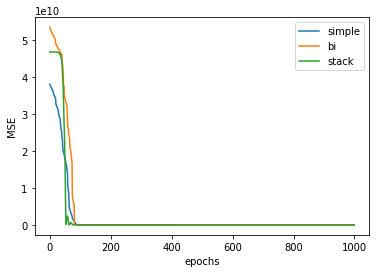

In [43]:
#PLOT MSE from the 3 graphs
pyplot.plot(history.history['mse'],label='simple')
pyplot.plot(bihistory.history['mse'],label='bi')
pyplot.plot(shistory.history['mse'],label='stack')
pyplot.xlabel("epochs")
pyplot.ylabel("MSE")
pyplot.legend()

In [41]:
def getAvgError(p, a):
    z = zip(p,a)
    e = []
    for i, j in z:
        e.append(abs(i-j))
    return sum(e)/len(a)

In [62]:
# SHOW ERROR TABLE
err_arch = []
for m in [model, smodel, bimodel]:
    p = np.squeeze(m.predict(X_test))
    e = getAvgError(p,y_test)
    err_arch.append(e)

pd.DataFrame([err_arch], columns=["Simple LSTM", "Stacked LSTM", "Bidirectional LSTM"])

,Simple LSTM,Stacked LSTM,Bidirectional LSTM
0,0.212647,0.202633,0.234644


### Compare Activations

In [82]:
# Simple LSTM - RELU Activation
m=50
model = Sequential()
model.add(LSTM(m, activation='relu', input_shape=(fib_look, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse',metrics=['mse'])
history = model.fit(X_train, y_train, epochs=1000, validation_split=0.2, verbose=0)

#try on prediction
print(X_test)
print("Prediction: " + str(np.squeeze(model.predict(X_test))))
print("Actual: " + str(y_test))

[[[1]
  [1]]

 [[1]
  [2]]

 [[2]
  [3]]]
Prediction: [2.3026855 2.8211935 4.988802 ]
Actual: [2 3 5]


In [83]:
# Simple LSTM - Sigmoid Activation
model2 = Sequential()
model2.add(LSTM(m, activation='sigmoid', input_shape=(fib_look, 1)))
model2.add(Dense(1))
model2.compile(optimizer='adam', loss='mse',metrics=['mse'])
history2 = model2.fit(X_train, y_train, epochs=1000, validation_split=0.2, verbose=0)

#try on prediction
print(X_test)
print("Prediction: " + str(np.squeeze(model2.predict(X_test))))
print("Actual: " + str(y_test))

[[[1]
  [1]]

 [[1]
  [2]]

 [[2]
  [3]]]
Prediction: [11.73003  11.787016 11.944893]
Actual: [2 3 5]


In [95]:
# Simple LSTM - Linear Activation
m=50
model3 = Sequential()
model3.add(LSTM(m, activation='linear', input_shape=(fib_look, 1)))
model3.add(Dense(1))
model3.compile(optimizer='adam', loss='mse',metrics=['mse'])
history3 = model3.fit(X_train, y_train, epochs=1000, validation_split=0.2, verbose=0)

#try on prediction
print(X_test)
print("Prediction: " + str(np.squeeze(model3.predict(X_test))))
print("Actual: " + str(y_test))

[[[1]
  [1]]

 [[1]
  [2]]

 [[2]
  [3]]]
Prediction: [2.6555212 3.0589612 5.1326575]
Actual: [2 3 5]


In [85]:
# Simple LSTM - TANH Activation
model4 = Sequential()
model4.add(LSTM(m, activation='tanh', input_shape=(fib_look, 1)))
model4.add(Dense(1))
model4.compile(optimizer='adam', loss='mse',metrics=['mse'])
history4 = model4.fit(X_train, y_train, epochs=1000, validation_split=0.2, verbose=0)

#try on prediction
print(X_test)
print("Prediction: " + str(np.squeeze(model4.predict(X_test))))
print("Actual: " + str(y_test))

[[[1]
  [1]]

 [[1]
  [2]]

 [[2]
  [3]]]
Prediction: [2.0673404 5.6786513 4.8972044]
Actual: [2 3 5]


In [94]:
# Simple LSTM - Softplus Activation
m = 50
model5 = Sequential()
model5.add(LSTM(m, activation='softplus', input_shape=(fib_look, 1)))
model5.add(Dense(1))
model5.compile(optimizer='adam', loss='mse',metrics=['mse'])
history5 = model5.fit(X_train, y_train, epochs=1000, validation_split=0.2, verbose=0)

#try on prediction
print(X_test)
print("Prediction: " + str(np.squeeze(model5.predict(X_test))))
print("Actual: " + str(y_test))

[[[1]
  [1]]

 [[1]
  [2]]

 [[2]
  [3]]]
Prediction: [2.3934603 3.4214082 4.9973035]
Actual: [2 3 5]


In [87]:
# Simple LSTM - exponential Activation
model6 = Sequential()
model6.add(LSTM(m, activation='exponential', input_shape=(fib_look, 1)))
model6.add(Dense(1))
model6.compile(optimizer='adam', loss='mse',metrics=['mse'])
history6 = model6.fit(X_train, y_train, epochs=1000, validation_split=0.2, verbose=0)

#try on prediction
print(X_test)
print("Prediction: " + str(np.squeeze(model6.predict(X_test))))
print("Actual: " + str(y_test))

[[[1]
  [1]]

 [[1]
  [2]]

 [[2]
  [3]]]
Prediction: [nan nan nan]
Actual: [2 3 5]


In [88]:
# Simple LSTM - ELU Activation
model7 = Sequential()
model7.add(LSTM(m, activation='elu', input_shape=(fib_look, 1)))
model7.add(Dense(1))
model7.compile(optimizer='adam', loss='mse',metrics=['mse'])
history7 = model7.fit(X_train, y_train, epochs=1000, validation_split=0.2, verbose=0)

#try on prediction
print(X_test)
print("Prediction: " + str(np.squeeze(model7.predict(X_test))))
print("Actual: " + str(y_test))

[[[1]
  [1]]

 [[1]
  [2]]

 [[2]
  [3]]]
Prediction: [2.6727412 3.142156  5.1536427]
Actual: [2 3 5]


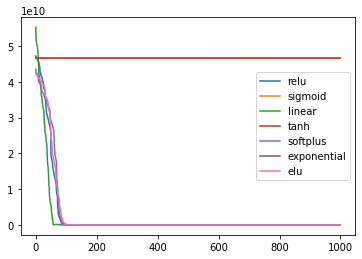

In [89]:
#compare all of them together
#PLOT MSE from the 7 graphs
pyplot.plot(history.history['mse'],label='relu')
pyplot.plot(history2.history['mse'],label='sigmoid')
pyplot.plot(history3.history['mse'],label='linear')
pyplot.plot(history4.history['mse'],label='tanh')
pyplot.plot(history5.history['mse'],label='softplus')
pyplot.plot(history6.history['mse'],label='exponential')
pyplot.plot(history7.history['mse'],label='elu')
pyplot.legend()

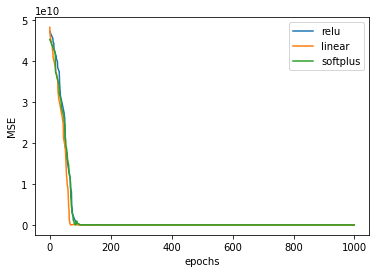

In [96]:
#print original and best
pyplot.plot(history.history['mse'],label='relu')
pyplot.plot(history3.history['mse'],label='linear')
pyplot.plot(history5.history['mse'],label='softplus')
pyplot.xlabel("epochs")
pyplot.ylabel("MSE")
pyplot.legend()

In [97]:
# SHOW ERROR TABLE
err_arch = []
for m in [model, model3, model5]:
    p = np.squeeze(m.predict(X_test))
    e = getAvgError(p,y_test)
    err_arch.append(e)

pd.DataFrame([err_arch], columns=["ReLU", "Linear", "Softplus"])

,ReLU,Linear,Softplus
0,0.16423,0.28238,0.272522


## Learn from one example

The bot needs to be able to approximate a recursive function that changes from sequence to sequence. Therefore, we need to come up with a network capable of learning and validating itself from one example

### Recursive (Fibonacci)

In [111]:
#length of input sequence is 4 numbers, guess the 5th
print(X_train[:2])
print(X_train[2])
print(y_train[2])

[[[ 610]
  [ 987]]

 [[ 987]
  [1597]]]
[[1597]
 [2584]]
4181


[[[34]
  [55]]]
Prediction: 91.160446
Actual: 89


Text(0.5, 1.0, 'Recursion Test')

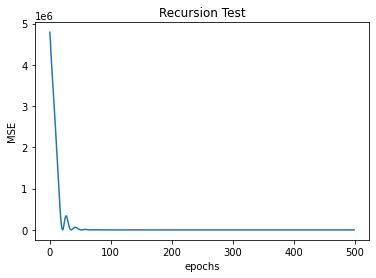

In [118]:
# Simple LSTM - softplus Activation
fib_model = Sequential()
fib_model.add(LSTM(50, activation='softplus', input_shape=(fib_look, 1)))
fib_model.add(Dense(1))
adam = keras.optimizers.Adam(lr=0.01)
fib_model.compile(optimizer=adam, loss='mse',metrics=['mse'])
fib_history = fib_model.fit([X_train[:2]], [y_train[:2]], epochs=500, verbose=0)

#predict on unseen
xt = np.expand_dims(X_train[3],0)
print(xt)
print("Prediction: " + str(np.squeeze(fib_model.predict(xt))))
print("Actual: " + str(y_train[3]))

#plot error
pyplot.plot(fib_history.history['mse'])
pyplot.xlabel("epochs")
pyplot.ylabel("MSE")
pyplot.title("Recursion Test")

### Index

In [109]:
#make dataset (input => index of number, output => value)
# function: A_n = (2n-1)*2n
ind_train = [[[1]],[[2]],[[3]]]     
ans_train = [[[2]],[[12]],[[30]]]
ind_test = [[[4]]]
ans_test = [[[56]]]

[[[4]]]
Prediction: 53.105938
Actual: [[[56]]]


Text(0.5, 1.0, 'Index Test')

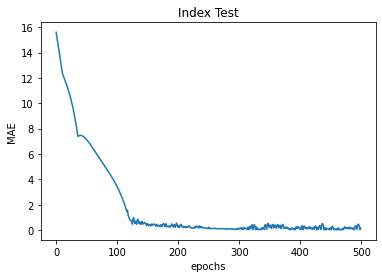

In [124]:
# Simple LSTM - softplus Activation
index_model = Sequential()
index_model.add(LSTM(50, activation='softplus', input_shape=(1, 1)))
index_model.add(Dense(1))
adam = keras.optimizers.Adam(lr=0.01)
index_model.compile(optimizer=adam, loss='mae',metrics=['mae'])
index_history = index_model.fit(ind_train, ans_train, epochs=500, validation_split=0.0, verbose=0)

#predict on unseen
print(ind_test)
print("Prediction: " + str(np.squeeze(index_model.predict(ind_test))))
print("Actual: " + str(ans_test))

#plot error
pyplot.plot(index_history.history['mae'])
pyplot.xlabel("epochs")
pyplot.ylabel("MAE")
pyplot.title("Index Test")

### Recursive and index hybrid

In [113]:
#remember format of fibonacci data
print(X_train.shape)
print(y_train.shape)

(30, 2, 1)
(30,)


In [114]:
#make dataset (input => [value (n), index of number], output => value (n+1))
# function: A_{n+1} = 2^{5-n} - A_n
n_train = [[[7],[1]],[[9],[2]],[[-1],[3]]]     
nplus_train = [[[9]],[[-1]],[[5]]]
n_test = [[[5],[4]]]
nplus_test = [[[-3]]]

[[[5], [4]]]
Prediction: -2.0652003
Actual: [[[-3]]]


Text(0.5, 1.0, 'Hybrid Test')

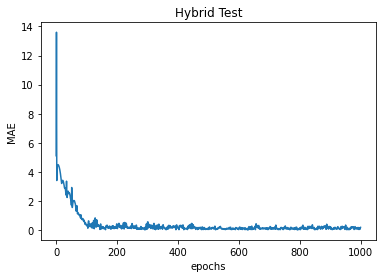

In [123]:
# simple LSTM - softplus Activation
hybrid_model = Sequential()
hybrid_model.add(LSTM(50, activation='softplus', input_shape=(2, 1)))
hybrid_model.add(Dense(1))
adam = keras.optimizers.Adam(lr=0.1)
hybrid_model.compile(optimizer=adam, loss='mae',metrics=['mae'])
hybrid_history = hybrid_model.fit(n_train, nplus_train, epochs=1000, validation_split=0.0, verbose=0)

#predict on unseen
print(n_test)
print("Prediction: " + str(np.squeeze(hybrid_model.predict(n_test))))
print("Actual: " + str(nplus_test))

#plot error
pyplot.plot(hybrid_history.history['mae'])
pyplot.xlabel("epochs")
pyplot.ylabel("MAE")
pyplot.title("Hybrid Test")

In [168]:
def getAvgError(p, a):
    z = zip(p,a)
    e = []
    for i, j in z:
        e.append(abs(i-j))
    return np.average(np.array(e))

In [178]:
import os

# REPEATED TRIALS OF THE THREE MODELS
trials = 10

#recursion model
rec_model_acc = []
for i in range(trials):
    print("RECURSION: " + str(i+1) + "/" + str(trials))
    # Simple LSTM - softplus Activation - recursion data
    fib_model = Sequential()
    fib_model.add(LSTM(50, activation='softplus', input_shape=(fib_look, 1)))
    fib_model.add(Dense(1))
    adam = keras.optimizers.Adam(lr=0.01)
    fib_model.compile(optimizer=adam, loss='mse',metrics=['mse'])
    fib_history = fib_model.fit([X_train[:2]], [y_train[:2]], epochs=500, verbose=0)

    #predict on unseen
    xt = np.expand_dims(X_train[3],0)
    p = fib_model.predict(xt)
    a = y_train[3]
    rec_model_acc.append(getAvgError([p],[a]))
    
print("\n")


#index model
ind_model_acc = []
for i in range(trials):
    print("INDEX: " + str(i+1) + "/" + str(trials))
    # Simple LSTM - softplus Activation - index data
    index_model = Sequential()
    index_model.add(LSTM(50, activation='softplus', input_shape=(1, 1)))
    index_model.add(Dense(1))
    adam = keras.optimizers.Adam(lr=0.01)
    index_model.compile(optimizer=adam, loss='mae',metrics=['mae'])
    index_history = index_model.fit(ind_train, ans_train, epochs=500, validation_split=0.0, verbose=0)

    #predict on unseen
    p = index_model.predict(ind_test)
    a = ans_test
    ind_model_acc.append(getAvgError([p],[a]))
    
print("\n")

#hybrid model
hyb_model_acc = []
for i in range(trials):
    print("HYBRID: " + str(i+1) + "/" + str(trials))
        
    # simple LSTM - softplus Activation - hybrid data
    hybrid_model = Sequential()
    hybrid_model.add(LSTM(50, activation='softplus', input_shape=(2, 1)))
    hybrid_model.add(Dense(1))
    adam = keras.optimizers.Adam(lr=0.1)
    hybrid_model.compile(optimizer=adam, loss='mae',metrics=['mae'])
    hybrid_history = hybrid_model.fit(n_train, nplus_train, epochs=1000, validation_split=0.0, verbose=0)

    #predict on unseen
    p = hybrid_model.predict(n_test)
    a = nplus_test
    hyb_model_acc.append(getAvgError([p],[a]))
    
print("\n")

RECURSION: 1/10
RECURSION: 2/10
RECURSION: 3/10
RECURSION: 4/10
RECURSION: 5/10
RECURSION: 6/10
RECURSION: 7/10
RECURSION: 8/10
RECURSION: 9/10
RECURSION: 10/10


INDEX: 1/10


INDEX: 2/10
INDEX: 3/10
INDEX: 4/10
INDEX: 5/10
INDEX: 6/10
INDEX: 7/10
INDEX: 8/10
INDEX: 9/10
INDEX: 10/10


HYBRID: 1/10
HYBRID: 2/10


HYBRID: 3/10
HYBRID: 4/10
HYBRID: 5/10
HYBRID: 6/10
HYBRID: 7/10
HYBRID: 8/10
HYBRID: 9/10
HYBRID: 10/10




In [179]:
rec_model_acc = rec_model_acc[:10]
ind_model_acc = ind_model_acc[:10]
hyb_model_acc = hyb_model_acc[:10]

rec_avg = np.average(np.squeeze(rec_model_acc))
ind_avg = np.average(np.squeeze(ind_model_acc))
hyb_avg = np.average(np.squeeze(hyb_model_acc))

rec_model_acc.append(rec_avg)
ind_model_acc.append(ind_avg)
hyb_model_acc.append(hyb_avg)

In [180]:
#rec_model_acc = list(map(lambda x: x.value, rec_model_acc))
#ind_model_acc = list(map(lambda x: x.value, ind_model_acc))
#hyb_model_acc = list(map(lambda x: x.value, hyb_model_acc))

i = list(range(1,11))
i.append("avg")

trial_dat = pd.DataFrame({"recursion model":rec_model_acc, 
                          "index model": ind_model_acc, 
                          "hybrid model": hyb_model_acc},
                         index=i)
print(trial_dat)

     recursion model  index model  hybrid model
1           3.055908     3.662125      1.063082
2           3.886070     2.273430      0.956628
3          11.684509     3.068684      1.996088
4          10.034424     2.110504      1.237063
5           1.692841     3.506943      1.011627
6           3.921051     2.922745      1.504955
7           1.496468     2.822330      1.231271
8           5.415962     3.196648      1.048980
9           5.132637     2.757069      1.202277
10          1.385681     2.768295      1.970452
avg         4.770555     2.908877      1.322242


#### Note: Needs to have better accuracy (-1.8 is too close to -1 (a possible answer choice) rather than -3 (the actual answer)